In [1]:
import os
import re
import glob
from datetime import datetime
import sys
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC, Heuristic
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator
from src.utils import print_metrics_as_md, pandas_df_to_markdown_table
# from src.pipeline import run_pipeline, prepare_data, evaluate_results
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## 1. 15 runs

- SimpleLSTM with seeds from 42 to 56
- On OC-3C and OC-3C+
- 90k train, 9k test
- 512 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_42   |     OC-3C    SLSTM_43   |     OC-3C    SLSTM_44   |     OC-3C    SLSTM_45   |     OC-3C    SLSTM_46   |     OC-3C    SLSTM_47   |     OC-3C    SLSTM_48   |     OC-3C    SLSTM_49   |     OC-3C    SLSTM_50   |     OC-3C    SLSTM_51   |     OC-3C    SLSTM_52   |     OC-3C    SLSTM_53   |     OC-3C    SLSTM_54   |     OC-3C    SLSTM_55   |     OC-3C    SLSTM_56   |     OC-3C+    SLSTM_42   |     OC-3C+    SLSTM_43   |     OC-3C+    SLSTM_44   |     OC-3C+    SLSTM_45   |     OC-3C+    SLSTM_46   |     OC-3C+    SLSTM_47   |     OC-3C+    SLSTM_48   |     OC-3C+    SLSTM_49   |     OC-3C+    SLSTM_50   |     OC-3C+    SLSTM_51   |     OC-3C+    SLSTM_52   |     OC-3C+    SLSTM_53   |     OC-3C+    SLSTM_54   |     OC-3C+    SLSTM_55   |     OC-3C+    SLSTM_56   |
|---:|:-----------------------------|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|-------------------------:|
|  0 | prec                         |                 0.36441 |                 0.35397 |                 0.38462 |                 0.36813 |                 0.37811 |                 0.37419 |                 0.38523 |                 0.34052 |                 0.3722  |                 0.39108 |                 0.35703 |                 0.38181 |                 0.36864 |                 0.34628 |                 0.37142 |                  0.22822 |                  0.32555 |                  0.36945 |                  0.36879 |                  0.31527 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  1 | rec                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  2 | f1                           |                 0.29667 |                 0.24276 |                 0.29404 |                 0.31864 |                 0.3297  |                 0.31781 |                 0.2985  |                 0.26826 |                 0.2745  |                 0.29808 |                 0.28126 |                 0.29798 |                 0.31248 |                 0.28542 |                 0.30624 |                  0.19255 |                  0.2956  |                  0.29925 |                  0.28082 |                  0.19564 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  3 | acc                          |                 0.37278 |                 0.35878 |                 0.381   |                 0.37911 |                 0.38744 |                 0.38322 |                 0.37844 |                 0.36167 |                 0.37011 |                 0.38311 |                 0.37022 |                 0.37833 |                 0.37867 |                 0.36544 |                 0.37789 |                  0.34022 |                  0.33311 |                  0.37656 |                  0.37322 |                  0.34011 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |
|  4 | mcc                          |                 0.07882 |                 0.06828 |                 0.10221 |                 0.08302 |                 0.09732 |                 0.09366 |                 0.094   |                 0.06191 |                 0.08404 |                 0.10601 |                 0.07855 |                 0.09329 |                 0.08554 |                 0.06459 |                 0.08684 |                  0.03069 |                 -0.00037 |                  0.08678 |                  0.08774 |                  0.02772 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |                        0 |


**Outcome**: Execution became very slow after a few iterations. Had to stop after 20 out of 30. Nevertheless OC-3C+ appears to be worse. The histories show that a the accuracy is not changing at all (especially on OC-3+) -> lower batch size / higher learning rate?

**Winner**: OC-3C

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-15-runs.csv")

## 2. 5 runs (bs=64)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 60k train, 6k test
- 64 batch size
- 150 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b64_42   |     OC-3C    SLSTM_b64_43   |     OC-3C    SLSTM_b64_44   |     OC-3C    SLSTM_b64_45   |     OC-3C    SLSTM_b64_46   |     OC-3C+    SLSTM_b64_42   |     OC-3C+    SLSTM_b64_43   |     OC-3C+    SLSTM_b64_44   |     OC-3C+    SLSTM_b64_45   |     OC-3C+    SLSTM_b64_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.11111 |                     0.32211 |                     0.22711 |                     0.31561 |                     0.23353 |                      0.11111 |                      0.11111 |                      0.36631 |                            0 |                            0 |
|  1 | rec                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  2 | f1                           |                     0.16667 |                     0.30668 |                     0.1786  |                     0.21627 |                     0.18374 |                      0.16667 |                      0.16667 |                      0.31404 |                            0 |                            0 |
|  3 | acc                          |                     0.33333 |                     0.34283 |                     0.33767 |                     0.3465  |                     0.33883 |                      0.33333 |                      0.33333 |                      0.37983 |                            0 |                            0 |
|  4 | mcc                          |                     0       |                     0.01561 |                     0.02991 |                     0.04257 |                     0.03177 |                      0       |                      0       |                      0.08696 |    

**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs64.csv")

## 3. 5 runs (bs=16)

- SimpleLSTM with seeds from 42 to 46
- On OC-3C and OC-3C+
- 45k train, 4.5k test
- 16 batch size
- 100 epochs

| -  |   datasets    predictors     |     OC-3C    SLSTM_b16_42   |     OC-3C    SLSTM_b16_43   |     OC-3C    SLSTM_b16_44   |     OC-3C    SLSTM_b16_45   |     OC-3C    SLSTM_b16_46   |     OC-3C+    SLSTM_b16_42   |     OC-3C+    SLSTM_b16_43   |     OC-3C+    SLSTM_b16_44   |     OC-3C+    SLSTM_b16_45   |     OC-3C+    SLSTM_b16_46   |
|---:|:-----------------------------|----------------------------:|----------------------------:|----------------------------:|----------------------------:|----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |                     0.25112 |                     0.11111 |                     0.11111 |                     0.11111 |                     0.11111 |                      0.11111 |                      0.11111 |                      0.2391  |                      0.11111 |                      0.11111 |
|  1 | rec                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  2 | f1                           |                     0.18983 |                     0.16667 |                     0.16667 |                     0.16667 |                     0.16667 |                      0.16667 |                      0.16667 |                      0.1848  |                      0.16667 |                      0.16667 |
|  3 | acc                          |                     0.34022 |                     0.33333 |                     0.33333 |                     0.33333 |                     0.33333 |                      0.33333 |                      0.33333 |                      0.33867 |                      0.33333 |                      0.33333 |
|  4 | mcc                          |                     0.03562 |                     0       |                     0       |                     0       |                     0       |                      0       |                      0       |                      0.03018 |                      0       |                      0       |


**Outcome**: Same problems. Even worse results for OC-3C

**Winner**: -

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/prices-5-runs-bs16.csv")

Failed settings:
- n_units=[128, 128], lstm_dropout=0.4, lr=0.001, bs=16, epoch=20, 45k
- n_units=[256, 256], bs=64, epoch=10, 150k

# 4. 2 runs on new test data

- SimpleLSTM with seeds from 42 to 43, Heuristics, MLP, SVC
- On OCM-3C
- 240k train, 48k test (not balanced)
- 64 batch size
- 100 epochs
- 64 & 64 units
- 0.001 learning rate

|  -   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    Heuristic_all   |     OCM-3C    Heuristic_l1   |     OCM-3C    Heuristic_l3   |     OCM-3C    MLP   |     OCM-3C    SVC   |
|:-----|-------------------------:|-------------------------:|-----------------------------:|----------------------------:|----------------------------:|--------------------:|--------------------:|
| prec |                  0.50297 |                  0.50447 |                      0.48738 |                     0.49216 |                     0.47567 |             0.50176 |             0.46663 |
| rec  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| f1   |                  0.52308 |                  0.52249 |                      0.49012 |                     0.49198 |                     0.50026 |             0.4658  |             0.47941 |
| acc  |                  0.56846 |                  0.56006 |                      0.61102 |                     0.49181 |                     0.57175 |             0.4454  |             0.62292 |
| mcc  |                  0.08959 |                  0.09124 |                      0.03097 |                     0.06258 |                     0.03274 |             0.06744 |             0.00323 |

- 300k train, 60k test (not balanced)

| -   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    SLSTM_s44   |     OCM-3C    SLSTM_s45   |     OCM-3C    SLSTM_s46   |
|----:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|
| prec |                   0.50293 |                   0.4975  |                   0.49854 |                   0.50154 |                   0.5016  |
| rec  |                   0.57063 |                   0.56078 |                   0.55942 |                   0.5645  |                   0.55707 |
| f1   |                   0.52398 |                   0.51929 |                   0.51967 |                   0.52249 |                   0.5215  |
| acc  |                   0.57063 |                   0.56078 |                   0.55942 |                   0.5645  |                   0.55707 |
| mcc  |                   0.08826 |                   0.07947 |                   0.07988 |                   0.08581 |                   0.08591 |

[comment]: <> (Execution Code: print_metrics_as_md "../reports/custom/all-baselines-slstm.csv")

| -  |   datasets    predictors     |     OCM-3C    SLSTM_b128_128_128   |     OCM-3C    SLSTM_b64_128_128   |     OCM-3C    SLSTM_b64_128_64   |     OCM-3C    SLSTM_b64_32_32   |     OCM-3C    SLSTM_b64_64_32   |     OCM-3C    SLSTM_b32_32_32   |     OCM-3C    SLSTM_b16_16_16   |     OCM-3C    SLSTM_b8_8_8   |     OCM-3C    SLSTM_b8_8_8(2)   |
|---:|:-----------------------------|-----------------------------------:|----------------------------------:|---------------------------------:|--------------------------------:|--------------------------------:|--------------------------------:|--------------------------------:|-----------------------------:|--------------------------------:|
|  0 | prec                         |                            0.4966  |                           0.49447 |                          0.49815 |                         0.50036 |                         0.5015  |                         0.50269 |                         0.50714 |                      0.50504 |                      0.51500 |
|  1 | rec                          |                            0.5485  |                           0.5448  |                          0.55992 |                         0.57728 |                         0.57017 |                         0.57622 |                         0.57520 |                      0.58367 |                      0.57900 |
|  2 | f1                           |                            0.51593 |                           0.51343 |                          0.5192  |                         0.52202 |                         0.52266 |                         0.52456 |                         0.52718 |                      0.52674 |                      0.53462 |
|  3 | acc                          |                            0.5485  |                           0.5448  |                          0.55992 |                         0.57728 |                         0.57017 |                         0.57622 |                         0.57520 |                      0.58367 |                      0.57900 |
|  4 | mcc                          |                            0.07971 |                           0.0756  |                          0.08366 |                         0.08933 |                         0.09105 |                         0.09185 |                         0.09787 |                      0.09470 |                      0.11367 |

#### Heuristics

| -  |   datasets    predictors     |     OCMvOC-3C    Heuristic_a-1   |     OCMvOC-3C    Heuristic_a0   |     OCMvOC-3C    Heuristic_a1   |     OCMvOC-3C    Heuristic_l1   |     OCMvOC-3C    Heuristic_rand   |     OCMvOC-3C    Heuristic_v_l1   |
|---:|:-----------------------------|---------------------------------:|--------------------------------:|--------------------------------:|--------------------------------:|----------------------------------:|----------------------------------:|
|  0 | prec                         |                          0.02781 |                         0.39088 |                         0.04328 |                         0.49883 |                           0.46474 |                           0.48106 |
|  1 | rec                          |                          0.16675 |                         0.6252  |                         0.20805 |                         0.49527 |                           0.33573 |                           0.53682 |
|  2 | f1                           |                          0.04766 |                         0.48102 |                         0.07166 |                         0.49701 |                           0.36472 |                           0.5019  |
|  3 | acc                          |                          0.16675 |                         0.6252  |                         0.20805 |                         0.49527 |                           0.33573 |                           0.53682 |
|  4 | mcc                          |                          0       |                         0       |                         0       |                         0.06813 |                           0.00359 |                           0.04332 |


[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-params.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-3.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-4.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-slstm-5.csv')
[comment]: <> (print_metrics_as_md '../reports/custom/all-baselines-heuristics.csv')

# 5. Final AI approaches

- SimpleLSTM with seeds from 42 to 46, MLP
- On OCM-3C and OCMvOC-3C (aborted during the 2. dataset)
- 300k train, 60k test (not balanced)
- 128 batch size
- 100 epochs
- 128 & 128 units
- 0.001 learning rate


| -  |   datasets    predictors     |     OCM-3C    MLP   |     OCM-3C    SLSTM_s42   |     OCM-3C    SLSTM_s43   |     OCM-3C    SLSTM_s44   |     OCM-3C    SLSTM_s45   |     OCM-3C    SLSTM_s46   |     OCMvOC-3C    MLP   |     OCMvOC-3C    SLSTM_s42   |     OCMvOC-3C    SLSTM_s43   |     OCMvOC-3C    SLSTM_s44   |     OCMvOC-3C    SLSTM_s45   |     OCMvOC-3C    SLSTM_s46   |
|---:|:-----------------------------|--------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|--------------------------:|-----------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|-----------------------------:|
|  0 | prec                         |             0.5062  |                   0.5017  |                   0.50005 |                   0.49935 |                   0.50105 |                   0.5021  |                0.37399 |                      0.44839 |                      0.47712 |                            0 |                            0 |                            0 |
|  1 | rec                          |             0.38905 |                   0.55497 |                   0.55277 |                   0.55835 |                   0.55803 |                   0.56537 |                0.21137 |                      0.29092 |                      0.33253 |                            0 |                            0 |                            0 |
|  2 | f1                           |             0.41822 |                   0.52137 |                   0.51972 |                   0.51997 |                   0.52126 |                   0.52347 |                0.18204 |                      0.3115  |                      0.35872 |                            0 |                            0 |                            0 |
|  3 | acc                          |             0.38905 |                   0.55497 |                   0.55277 |                   0.55835 |                   0.55803 |                   0.56537 |                0.21137 |                      0.29092 |                      0.33253 |                            0 |                            0 |                            0 |
|  4 | mcc                          |             0.05772 |                   0.08206 |                   0.07897 |                   0.07759 |                   0.08078 |                   0.08343 |               -0.03582 |                     -0.01074 |                      0.02517 |                            0 |                            0 |                            0 |

**Outcome:** LSTM can't learn useful information from too much feature dimensions.

[comment]: <> (print_metrics_as_md "../reports/custom/ml-baselines-2.csv")

## 6. All Baselines

| -  |   datasets    predictors     |     OCMvOC-3C    Heuristic_all   |     OCMvOC-3C    Heuristic_l1   |     OCMvOC-3C    Heuristic_l3   |     OCMvOC-3C    Heuristic_v_l1   |     OCMvOC-3C    MLP   |     OCMvOC-3C    SLSTM   |     OCMvOC-3C    SVC   |
|---:|:-----------------------------|---------------------------------:|--------------------------------:|--------------------------------:|----------------------------------:|-----------------------:|-------------------------:|-----------------------:|
|  0 | prec                         |                          0.48365 |                         0.49756 |                         0.48274 |                           0.47925 |                0.40024 |                  0.48386 |                0.52198 |
|  1 | rec                          |                          0.61467 |                         0.49363 |                         0.57635 |                           0.53523 |                0.22668 |                  0.60472 |                0.62097 |
|  2 | f1                           |                          0.49376 |                         0.49556 |                         0.50701 |                           0.50027 |                0.2169  |                  0.4935  |                0.48285 |
|  3 | acc                          |                          0.61467 |                         0.49363 |                         0.57635 |                           0.53523 |                0.22668 |                  0.60472 |                0.62097 |
|  4 | mcc                          |                          0.03026 |                         0.06588 |                         0.0397  |                           0.04045 |               -0.03705 |                  0.02065 |                0.00765 |

**Outcome**: Abort since LSTM didn't work correctly -> Optimized parameters again in experiment 4.2

## 7. SLSTM - Epochs
- SLSTM_b16_16_16
- train 300k, test 60k (not balanced)
- seed 42 (default)
- OCM-3C
- Epochs: 1, 5, 10, 30, 60, 100

MCC: 0.064, 0.084, 0.085, 0.096, 0.098, 0.102

[comment]: <> (print_metrics_as_md "../reports/custom/slstm-epochs.csv")

## Final Baselines

TODO: Execute after SLSTM is optimized and works on OCMvOC-3C

In [2]:
datasets = [
#     NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv', epsilon=0.0055, companies=['GOOGL', 'GOOG', 'AXP', 'GM', 'WMT', 'AMZN', 'APC', 'MSFT']),
#     NyseStocksDataset('OCM-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement']),
    NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close']),
#     NyseStocksDataset('OC-3C+', file_path='../data/nyse/prices-split-adjusted.csv'),
]
[ds.load() for ds in datasets];


time: 12.2 s


2019-01-23 00:57:02 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2019-01-23 00:57:03 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2019-01-23 00:57:03 [INFO] src.preparation: Training range: 2010-01-13 00:00:00 to 2014-06-27 00:00:00
2019-01-23 00:57:04 [INFO] src.preparation: Test Labels --> -1.0: 10535; 0.0: 37233; 1.0: 12232
2019-01-23 00:57:04 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2019-01-23 00:57:04 [INFO] src.preparation: Done preparing data
2019-01-23 00:57:04 [INFO] src.evaluation.evaluator: ---------- Heu_l1 | OCMvOC-3C ----------
2019-01-23 00:57:05 [INFO] src.evaluation.evaluator: ---------- Heu_all | OCMvOC-3C ----------
2019-01-23 00:57:07 [INFO] src.evaluation.evaluator: ---------- Heu_l3 | OCMvOC-3C ----------
2019-01-23 00:57:09 [INFO] src.evaluation.evaluator: ---------- Heu_v_l1 | OCMvOC-3C ----------
2019-01-23 00:57:11 [INFO] src.evaluation.evaluator: ---------- H

c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-01-23 00:57:13 [INFO] src.evaluation.evaluator: ---------- Heu_a0 | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-01-23 00:57:15 [INFO] src.evaluation.evaluator: ---------- Heu_a1 | OCMvOC-3C ----------


c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thomas\hpi\ma\venv\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-01-23 00:57:17 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=42) | OCMvOC-3C ----------



2019-01-23 02:44:56 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=43) | OCMvOC-3C ----------



2019-01-23 04:33:29 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=44) | OCMvOC-3C ----------



2019-01-23 06:23:22 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=45) | OCMvOC-3C ----------



2019-01-23 08:12:46 [INFO] src.evaluation.evaluator: ---------- SimpleLSTM(s=46) | OCMvOC-3C ----------



2019-01-23 10:08:49 [INFO] src.evaluation.evaluator: Store evaluator results at C:\Users\Thomas\HPI\MA\reports\evaluators\baselines-2019-01-23-100849.pkl
2019-01-23 10:08:49 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=42)-on-OCMvOC-3C-2019-01-23-100849.png
2019-01-23 10:08:49 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=43)-on-OCMvOC-3C-2019-01-23-100849.png
2019-01-23 10:08:49 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=44)-on-OCMvOC-3C-2019-01-23-100849.png
2019-01-23 10:08:50 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=45)-on-OCMvOC-3C-2019-01-23-100850.png
2019-01-23 10:08:50 [INFO] src.evaluation.plotter: Stored plot at ../reports\figures/exp-baselines\histories\history--SimpleLSTM(s=46)-on-OCMvOC-3C-2019-01-23-100850

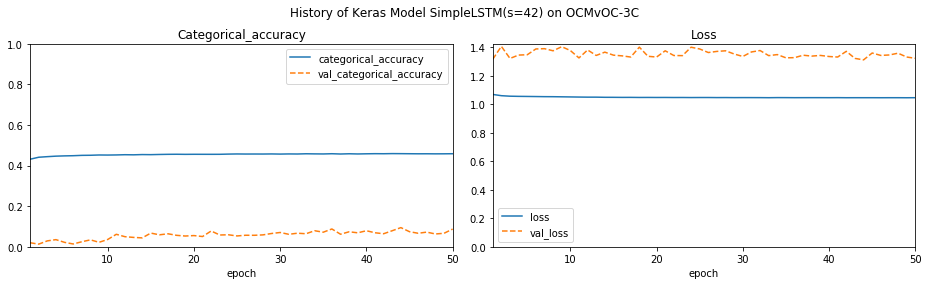

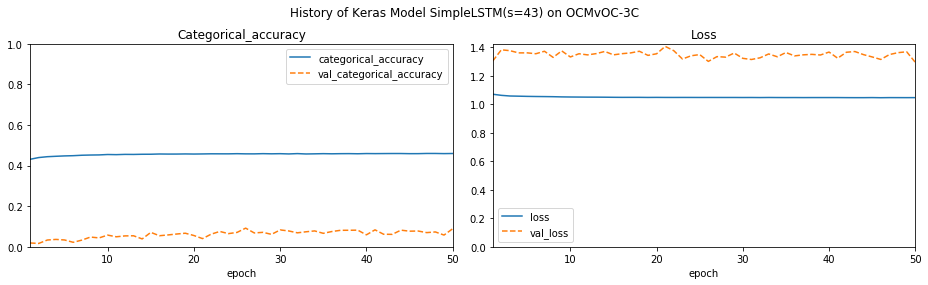

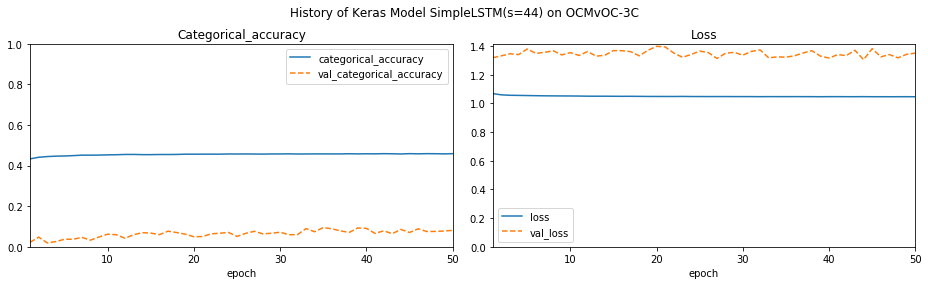

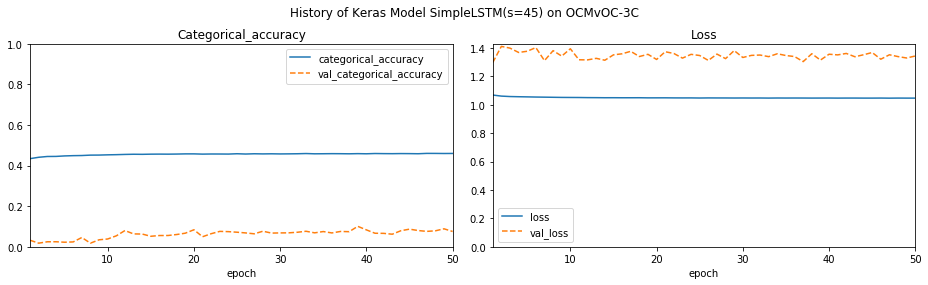

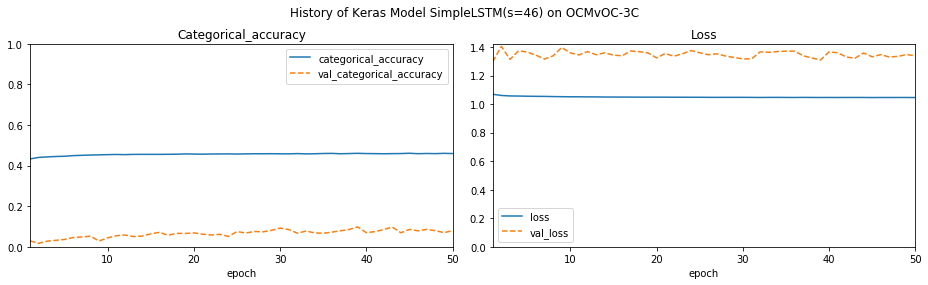

time: 9h 11min 49s


In [17]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    seeds = range(42, 47)
    return [
        Heuristic('_l1', n_features, n_timestamps, Heuristic.last_movement, movement_feat=-3),
        Heuristic('_all', n_features, n_timestamps, Heuristic.mean_movement, movement_feat=-3),
        Heuristic('_l3', n_features, n_timestamps, Heuristic.last_three_movements, movement_feat=-3),
        Heuristic('_v_l1', n_features, n_timestamps, Heuristic.last_vix_movement, vix_feats=[-2, -1]),
        Heuristic('_a-1', n_features, n_timestamps, Heuristic.one_class, one_class=-1),
        Heuristic('_a0', n_features, n_timestamps, Heuristic.one_class, one_class=0),
        Heuristic('_a1', n_features, n_timestamps, Heuristic.one_class, one_class=1),
        *[SimpleLSTM(ignore_features=[-2, -1], n_timestamps=n_timestamps, n_features=n_features, n_classes=n_classes, seed=s) for s in seeds]
    ]
evaluator = Evaluator('baselines', datasets, get_predictors, '../reports', store=True,
                      n_train_samples=300000, n_test_samples=60000, downsample=True)
metrics = evaluator()

In [18]:
evaluator.metrics

predictor,OCMvOC-3C Heu_a-1,OCMvOC-3C Heu_a0,OCMvOC-3C Heu_a1,OCMvOC-3C Heu_all,OCMvOC-3C Heu_l1,OCMvOC-3C Heu_l3,OCMvOC-3C Heu_v_l1,OCMvOC-3C SimpleLSTM
prec,0.03083,0.38508,0.04156,0.48468,0.49242,0.4761,0.47644,0.50213 +- 0.00222
rec,0.17558,0.62055,0.20387,0.61028,0.49187,0.57217,0.53722,0.57962 +- 0.00388
f1,0.05245,0.47525,0.06905,0.48922,0.49214,0.50018,0.49805,0.52326 +- 0.00191
acc,0.17558,0.62055,0.20387,0.61028,0.49187,0.57217,0.53722,0.57962 +- 0.00388
mcc,0,0,0,0.03207,0.06432,0.03464,0.04507,0.09288 +- 0.00419


time: 240 ms


In [ ]:
# evaluator._metrics.to_csv(os.path.join(evaluator.output_dir, f'custom/{evaluator.name}.csv'))
# evaluator.plot_histories()
# [comment]: <> (print_metrics_as_md "../reports/custom/ml-baselines-2.csv")
# print_metrics_as_md("../reports/custom/ml-baselines-2.csv")

### Latex Export

In [81]:
e = Evaluator('baselines', datasets, get_predictors, output_dir='../reports').import_results()
e.metrics.columns = e.metrics.columns.str.replace('OCMvOC-3C ', '')
e.metrics = e.metrics[['Heu_a-1', 'Heu_a0', 'Heu_a1', 'Heu_v_l1', 'Heu_all', 'Heu_l3', 'Heu_l1', 'SimpleLSTM']]
e.metrics.columns = ['A_-1', 'A_0', 'A_1', 'HV_1d', 'HS_7d', 'HS_3d', 'HS_1d', 'LSTM']
latex_str = e.metrics.to_latex(column_format='c'*(len(e.metrics.columns)+1), escape=False, bold_rows=True)
latex_str = latex_str.replace(r'\begin{tabular}{', r'\begin{tabular}{\textwidth}{@{\extracolsep{\fill}}')
latex_str = latex_str.replace('{tabular}', '{tabular*}')
latex_str = latex_str.replace(r'\textbf{predictor}', '{}')
head_str, body_str = latex_str.split(r'\midrule')
head_str = re.sub(r'&(\W+)(\S+)', r'&\1$\mathbf{\2}$', head_str)
head_str = re.sub(r'\$(\S+)_(\S+)\$', r'$\1_{\2}$', head_str)
body_str = re.sub(r'(\d\.\d{3})\d*', r'\1', body_str)
body_str = re.sub(r'(\S+) \+- (\S+)', r'$\1 \pm \2$', body_str)
latex_str = fr'{head_str}\midrule{body_str}'
print(f'\n{latex_str}')

2019-01-24 01:56:25 [INFO] src.evaluation.evaluator: Found 2 possible matches. Selecting the latest one.
2019-01-24 01:56:25 [INFO] src.evaluation.evaluator: Read evaluator results at C:\Users\Thomas\HPI\MA\reports\evaluators\baselines-2019-01-23-100849.pkl

\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}ccccccccc}
\toprule
{} &     $\mathbf{A_{-1}}$ &      $\mathbf{A_{0}}$ &      $\mathbf{A_{1}}$ &    $\mathbf{HV_{1d}}$ &    $\mathbf{HS_{7d}}$ &    $\mathbf{HS_{3d}}$ &    $\mathbf{HS_{1d}}$ &                $\mathbf{LSTM}$ \\
\midrule
\textbf{prec} &  0.030 &  0.385 &  0.041 &  0.476 &  0.484 &   0.476 &  0.492 &  $0.502 \pm 0.002$ \\
\textbf{rec } &  0.175 &  0.620 &  0.203 &  0.537 &  0.610 &  0.572 &  0.491 &  $0.579 \pm 0.003$ \\
\textbf{f1  } &  0.052 &  0.475 &  0.069 &  0.498 &  0.489 &  0.500 &  0.492 &  $0.523 \pm 0.001$ \\
\textbf{acc } &  0.175 &  0.620 &  0.203 &  0.537 &  0.610 &  0.572 &  0.491 &  $0.579 \pm 0.003$ \\
\textbf{mcc } &        0 &        0 &        0 & 